In [ ]:
# Install CudaQ package
!pip install cudaq

from IPython.display import clear_output
clear_output()

In [1]:
import cudaq

In [2]:
import numpy as np
import scipy as sp
from numpy import linalg as LA
from copy import deepcopy
from numpy import matmul
import math
import matplotlib.pyplot as plt

In [3]:
# Check the hermitian matrix
def check_hermitian(mat):
  if np.allclose(mat, mat.T.conjugate(), rtol=1e-05, atol=1e-08):
    pass
  else:
    print("Sorry! The input matrix should be Hermitian.")

In [4]:
# Define linear system
# A = 0.25*np.array([[15.,9,5,-3],[9,15,3,-5],[5.,3,15,-9],[-3.,-5,-9,15]])
# b = 0.5*np.array([1,1,1,1]).T

A = np.array([[0, 1, 1, 0], [1, -1, 0, 0], [1, 0, -.5, 0], [0,0,0,1]])
b = np.array([0, 0, -.5, 0])

# Normalize vector b
norm_b = LA.norm(b)
A = A / norm_b
b = b / norm_b

# Exact solution 
csol = LA.solve(A,b)
check_hermitian(A)
print("Condition number of A: ", LA.cond(A))
print("Eigenvalues of A: ", LA.eigvals(A))

Condition number of A:  2.575130738580152
Eigenvalues of A:  [ 2.20147234 -3.74656825 -1.45490409  2.        ]


In [5]:
# Modified version of QFT available on CudaQ documentation: swaps added.
@cudaq.kernel
def QFT(qubits: cudaq.qview):
    '''Args:
    qubits (cudaq.qview): specifies the quantum register to which apply the QFT.'''
    qubit_count = len(qubits)
    # For this specific instance, following swaps should be added
    swap(qubits[1], qubits[qubit_count - 2])
    swap(qubits[0], qubits[qubit_count - 1])
    
    # Apply Hadamard gates and controlled rotation gates.
    for i in range(qubit_count):
        h(qubits[i])
        for j in range(i + 1, qubit_count):
            angle = -(2 * np.pi) / (2**(j - i + 1))
            cr1(angle, [qubits[j]], qubits[i])

# Inverse of QFT can be accessed by applying adjoint operator.
@cudaq.kernel
def invQFT(qubits: cudaq.qview):
    '''Args:
    qubits (cudaq.qview): specifies the quantum register to which apply the inverse QFT.'''
    cudaq.adjoint(QFT, qubits)

In [6]:
# Parameters
c_num = 4
b_num = int(np.log2(len(b)))

In [7]:
# Calculating the unitary matrices need for Hamiltonian simulation 
U = {}
t = 3*np.pi
for i in range(c_num):
    time = t/(2**(c_num - i))
    U[i] = sp.linalg.expm(-1j * A * time)
    cudaq.register_operation(f"U{i}", U[i])
# print(U)

In [8]:
# Calculating the unitary matrices need for inverse Hamiltonian simulation step
Uinv = {}
for i in range(c_num-1,-1,-1):
    time = t/(2**(c_num-i))
    Uinv[i] = sp.linalg.expm(-1j * -A * time)
    cudaq.register_operation(f"Uinv{i}", Uinv[i])
# print(Uinv)

In [9]:
# Checking if U and Uinv matrices are unitary
for i in range(len(U.keys())):
    print(f"Is U{i} unitary?    ", np.allclose(U[i] @ U[i].conj().T, np.eye(U[i].shape[0])))
    
for i in range(len(Uinv.keys())):
    print(f"Is Uinv{i} unitary? ", np.allclose(U[i] @ U[i].conj().T, np.eye(U[i].shape[0])))

Is U0 unitary?     True
Is U1 unitary?     True
Is U2 unitary?     True
Is U3 unitary?     True
Is Uinv0 unitary?  True
Is Uinv1 unitary?  True
Is Uinv2 unitary?  True
Is Uinv3 unitary?  True


In [10]:
@cudaq.kernel

def QuantumLinearSystemSolver(r: int, t: float):
    """
    A: The matrix representing the linear system.
    b: The vector representing the right-hand side of the linear system.
    t: A time parameter used in the controlled-Hamiltonian operations.
    r: A parameter used to determine the rotation angles for the ancilla qubit.
    shots: The number of shots (repetitions) for the quantum circuit execution.
    """
    #==========================================================================
    # Preprocessing
    #==========================================================================
    # check_hermitian(A)

    # # Normalize A and b
    # norm_b = LA.norm(b)
    # A = A / norm_b
    # b = b / norm_b

    # # Calculate condition number and eigenvalues of A
    # kappa = LA.cond(A)
    # eigs = LA.eigvals(A)

    #==========================================================================
    # Quantum Circuit
    #==========================================================================

    # Qubits
    qAnc = cudaq.qubit()
    cReg = cudaq.qvector(c_num)
    bReg = cudaq.qvector(b)       # Giving vector b to qvector initializes the quantum state.

    # Classical bits
    cAnc = [0]
    bVec = [0 for i in range(b_num)]


    # Apply Hadamard on register C
    h(cReg)

    # Apply Hamiltonian 
    for i in range(c_num):
        if i == 0:
            U0.ctrl([cReg[i]], bReg[0], bReg[1])
        if i == 1:
            U1.ctrl([cReg[i]], bReg[0], bReg[1])
        if i == 2:
            U2.ctrl([cReg[i]], bReg[0], bReg[1])
        if i == 3:
            U3.ctrl([cReg[i]], bReg[0], bReg[1])
            
    # Apply inverse QFT
    QFT(cReg)

    # Swap the qubit
    swap(cReg[1], cReg[c_num - 1])

    # Apply y rotations on Ancilla qubit
    for i in range(c_num):
        exponent = c_num - r - i
        theta = np.pi/(2**(-exponent))
        ry.ctrl(theta, [cReg[i]], qAnc)  
        
    # # ================ Uncompute the circuit ================
    
    # Swap the qubit
    swap(cReg[1], cReg[c_num - 1])

    # Apply QFT
    invQFT(cReg)

    # Apply Hamiltonian
    for i in range(c_num-1,-1,-1):
        if i == 0:
            Uinv0.ctrl([cReg[i]], bReg[0], bReg[1])
        if i == 1:
            Uinv1.ctrl([cReg[i]], bReg[0], bReg[1])
        if i == 2:
            Uinv2.ctrl([cReg[i]], bReg[0], bReg[1])
        if i == 3:
            Uinv3.ctrl([cReg[i]], bReg[0], bReg[1])

    # Apply Hadamard on register C
    h(cReg)

    # Measurement
    mz(qAnc)
    mz(bReg)

In [11]:
# Extract approximate solution of the quantum linear solver
def approximate_quantum_sol(sol,b_num):
  num = 0
  app_sol = np.zeros(2**(b_num))

  for key, value in sol.items(): 
    if key[0] == '1':
      num += value 
      cord = int(key[-1:0:-1],base=2)
      app_sol[cord] = value
  
  app_sol = 1/num *app_sol
  return app_sol

print("Please run the quantum solver.")

Please run the quantum solver.


In [12]:
# Do the experiment
shots = 30000             # total number of running the circuit
SampleResults = cudaq.sample(QuantumLinearSystemSolver, 6, 3*np.pi, shots_count= shots)

MostProbableResult = SampleResults.most_probable()
Prob = SampleResults.probability(MostProbableResult)
print("Sample Results: \n")
print(SampleResults)
print("Most probable result: " + MostProbableResult)
print("Measured with probability " + str(Prob), end='\n\n')  

qsol = np.sqrt(approximate_quantum_sol(SampleResults,b_num))

print("============================== Final results ==============================\n")
print ('Exact solution = ', csol)
print('Quantum solver solution = ', qsol)
print('Norm of difference = ', LA.norm(qsol- csol),'\n')

Sample Results: 

{ 000:107 001:26945 010:71 100:585 101:1589 110:703 }

Most probable result: 001
Measured with probability 0.8981666666666667

============================== Final results ==============================

Exact solution =  [-0.33333333 -0.33333333  0.33333333  0.        ]
Quantum solver solution =  [0.45092883 0.49431949 0.74317658 0.        ]
Norm of difference =  1.211630232955281 



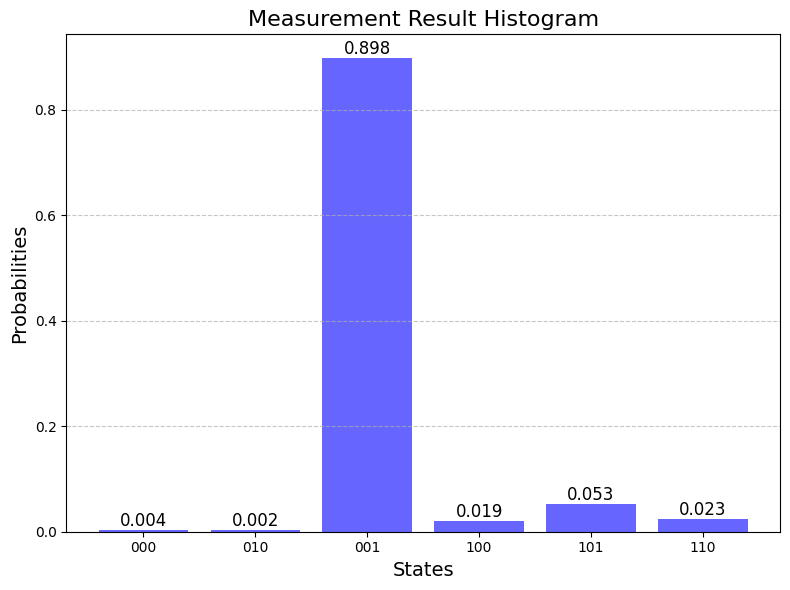

Note: In contrast to Qiskit which uses little-endian, CudaQ uses big-endian!


In [13]:
# Extract keys and values
states = []
probabilities = []
for key, value in SampleResults.items():
    states.append(key)
    probabilities.append(value/shots)

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(states, probabilities, color='blue', alpha=0.6)

# Add labels and title
plt.xlabel('States', fontsize=14)
plt.ylabel('Probabilities', fontsize=14)
plt.title('Measurement Result Histogram', fontsize=16)

# Add bar labels
for i, prob in enumerate(probabilities):
    plt.text(i, prob, f'{prob:.3f}', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Note: In contrast to Qiskit which uses little-endian, CudaQ uses big-endian!")

In [14]:
# Draw the quantum circuit
print("============================== Circuit structure ============================== \n")
print(cudaq.draw(QuantumLinearSystemSolver, 6, 3*np.pi))

============================== Circuit structure ============================== 

                                                                       »
q0 : ──────────────────────────────────────────────────────────────────»
     ╭───╮                           ╭───╮╭────────────╮╭─────────────╮»
q1 : ┤ h ├──●──────────────────────╳─┤ h ├┤ r1(-1.571) ├┤ r1(-0.7854) ├»
     ├───┤  │                      │ ╰───╯╰─────┬──────╯╰──────┬──────╯»
q2 : ┤ h ├──┼─────●───────────╳────┼────────────●──────────────┼───────»
     ├───┤  │     │           │    │                           │       »
q3 : ┤ h ├──┼─────┼─────●─────╳────┼───────────────────────────●───────»
     ├───┤  │     │     │          │                                   »
q4 : ┤ h ├──┼─────┼─────┼─────●────╳───────────────────────────────────»
     ╰───╯╭─┴──╮╭─┴──╮╭─┴──╮╭─┴──╮                                     »
q5 : ─────┤>   ├┤>   ├┤>   ├┤>   ├─────────────────────────────────────»
          │ U0 ││ U1 ││ U2 ││ U3 │        